In [1]:
import pandas as pd
import glob
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
# https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees

### Loading  Data

In [2]:
train_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_train_summary.csv")
test_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_test_summary.csv")

In [3]:
print(train_data.shape)
test_data.shape

(201917, 95)


(123623, 93)

### Functions to concatenate features, kfold splits

In [4]:
def feature_concat(train_data1,filepath):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1=pd.merge(train_data1, data_features, how='left', on='card_id')
    return(train_data1)

In [5]:
def kfold_split(splitcount, train_data1, ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ignore_cols]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include=numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X,train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

### Concatenate features

In [8]:
%%time
file_list = glob.glob("C:/Kaggle competetion datasets/Elo Merchent Category Recommendation/Elo Feb 18th/*.csv")
train_features = feature_concat(train_data,file_list)

Wall time: 160 ms


In [9]:
train_features.shape

(201917, 95)

In [20]:
# train_features=train_data.copy()

In [ ]:
# # Create correlation matrix
# corr_matrix = train_features.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# train_features=train_features1.drop(to_drop, axis=1).copy()

### Binning target variable

In [10]:
# Binning the numeric variable to different categories
target_std=train_features['target'].std()
max_target=train_features['target'].max()+1
min_target=train_features['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,5]
train_features['target_bin']=pd.cut(train_features['target'],bins=bins,labels=labels).astype(int)
train_features['target_bin']=train_features['target_bin'].abs()
train_features.groupby(['target_bin']).size()


target_bin
0    191093
2      8200
3       363
4      2237
5        24
dtype: int64

### KFold Splits

In [11]:
%%time
kfolds = kfold_split(5,train_features,['first_active_month', 'card_id','target','target_bin','year_nunique_y','year_nunique_x', 'outliers', 'Unnamed: 0'])

Wall time: 1.07 s


### LGBM

In [12]:
def run_lgb(train_X, train_y, val_X, val_y):
    param = {'num_leaves': 30,
             'min_data_in_leaf': 177,
             'objective': 'regression',
             'max_depth': 9,
             'learning_rate': 0.01,
             "boosting": "gbdt",
#              "feature_fraction": 0.7,
             "bagging_freq": 1,
             "bagging_fraction": 0.7,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "random_state": 133,
             "verbosity": -1}

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(param, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)
    return model, evals_result

In [13]:
best_iter_dict = {}
best_score_dict = {} 
feature_imp = pd.DataFrame()


eval_results_dict = {}
for split in range(0,5):
    model, evals_result = run_lgb(kfolds[split][0], kfolds[split][2], kfolds[split][1], kfolds[split][3])
    
    best_iter_dict.update({split:model.best_iteration})
    best_score_dict.update({split:model.best_score.get('valid_0').get('rmse')})
    feature_imp[split] = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.69821
[200]	valid_0's rmse: 3.66417
[300]	valid_0's rmse: 3.65022
[400]	valid_0's rmse: 3.64295
[500]	valid_0's rmse: 3.63918
[600]	valid_0's rmse: 3.63656
[700]	valid_0's rmse: 3.63538
[800]	valid_0's rmse: 3.63406
[900]	valid_0's rmse: 3.63376
[1000]	valid_0's rmse: 3.63319
[1100]	valid_0's rmse: 3.63271
[1200]	valid_0's rmse: 3.63273
Early stopping, best iteration is:
[1184]	valid_0's rmse: 3.63261
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72337
[200]	valid_0's rmse: 3.69253
[300]	valid_0's rmse: 3.68158
[400]	valid_0's rmse: 3.676
[500]	valid_0's rmse: 3.67183
[600]	valid_0's rmse: 3.6697
[700]	valid_0's rmse: 3.66842
[800]	valid_0's rmse: 3.66745
[900]	valid_0's rmse: 3.6671
[1000]	valid_0's rmse: 3.66683
[1100]	valid_0's rmse: 3.66654
Early stopping, best iteration is:
[1054]	valid_0's rmse: 3.66621
Training until validation scores don't improve for 

In [ ]:
best_iter_df = pd.DataFrame.from_dict(best_iter_dict, orient='index')
best_score_df = pd.DataFrame.from_dict(best_score_dict, orient='index')
feature_imp['Mean'] = feature_imp.mean(axis=1) 
feature_imp['Col_Names'] = kfolds[split][0].head().columns

In [27]:
feature_imp = feature_imp.sort_values(by='Mean',ascending=False)

In [28]:
feature_imp.head()

,0,1,2,3,4,Mean,Col_Names
29,1929,1679,1877,2101,1732,1863.6,hist_month_diff_mean
80,1214,1145,1201,1419,1250,1245.8,new_hist_purchase_date_uptonow
31,1231,1163,1242,1260,1172,1213.6,hist_authorized_flag_mean
55,1250,1136,1267,1215,1058,1185.2,new_hist_purchase_amount_max
34,1073,988,967,1251,951,1046.0,hist_category_1_sum


In [15]:
best_score_df

,0
0,3.632611
1,3.666208
2,3.642413
3,3.667577
4,3.645449


In [115]:
best_iter_df

,0
0,1184
1,1054
2,1124
3,1257
4,1067


In [32]:
best_score_df.columns = ['18th_feb_features']
best_score_df

,18th_feb_features
0,3.632611
1,3.666208
2,3.642413
3,3.667577
4,3.645449


In [35]:
best_score_df.to_excel('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\best_scores.xlsx',
                       sheet_name='best_scores', index=False)

In [36]:
print(best_score_df.mean(axis = 0))

18th_feb_features    3.650852
dtype: float64


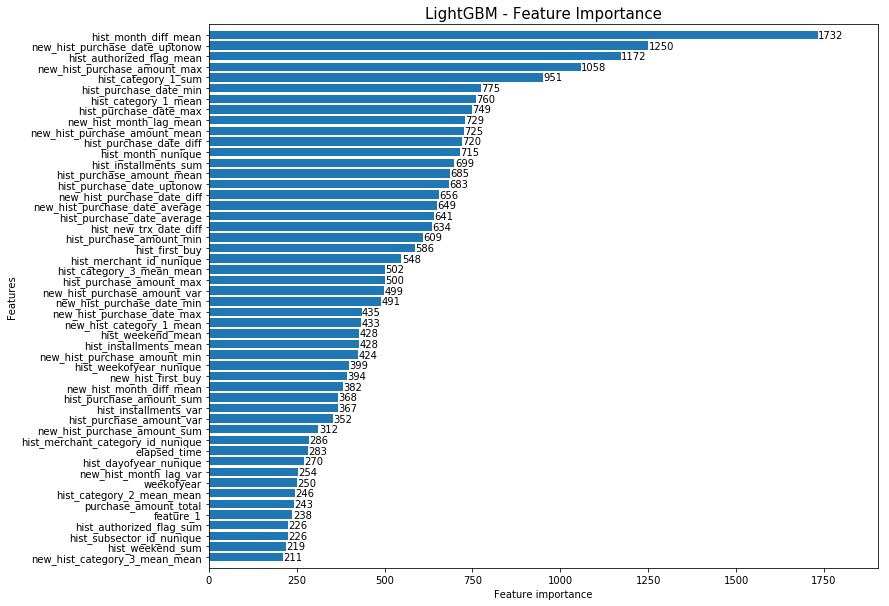

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### With Mean Feature_Importance

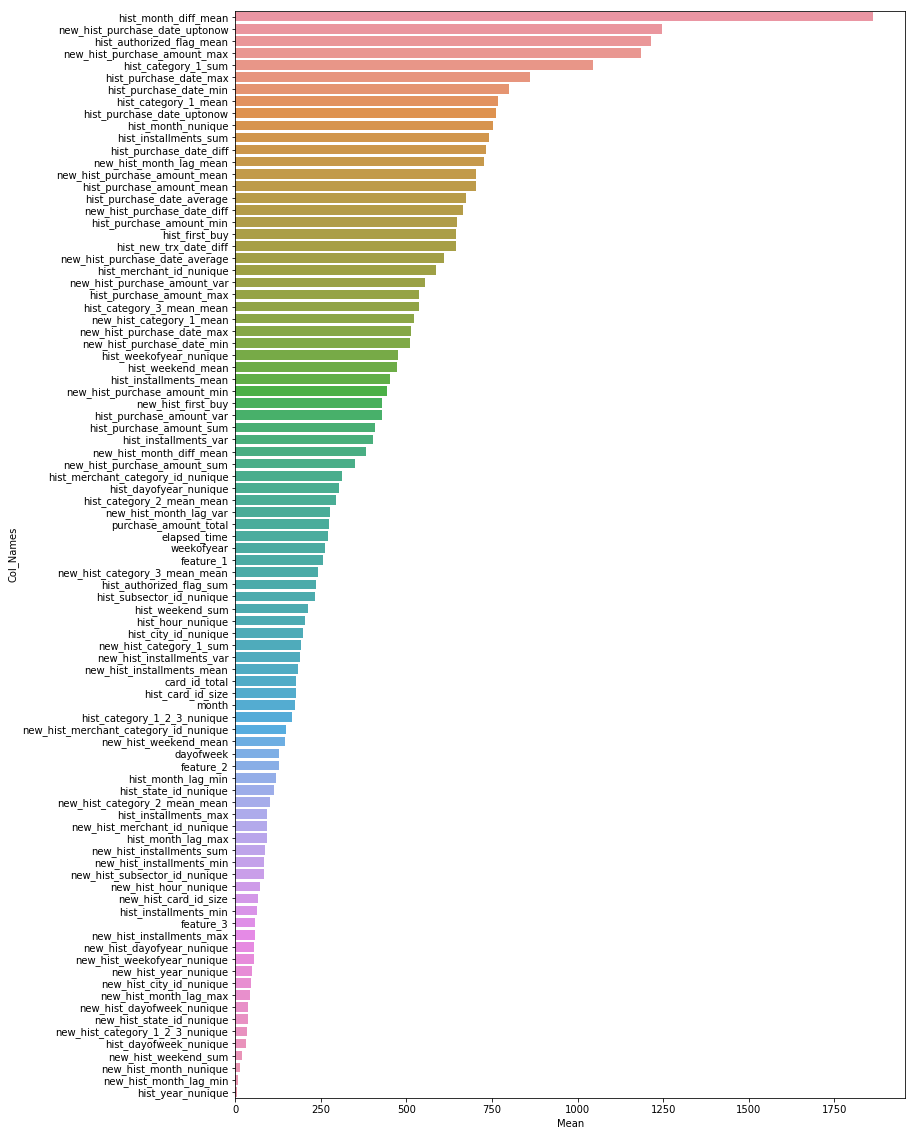

In [29]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,20))
sns.barplot(x="Mean", y="Col_Names", data = feature_imp, orient='h',ax=ax)
plt.show()

### Slicing Imp_Features Percentage Wise

In [97]:
def df_slice_train(df, percentage):
    
    top_features = df.iloc[int(len(df)*0.0):int(len(df)*percentage)]
    
    imp_columns = pd.DataFrame()
    for i in top_features['Col_Names'].values:
        imp_columns[i] = train_features[i]
    
    #imp_columns['dummy'] = 1
    imp_columns['target_bin'] = train_features['target_bin']
    imp_columns['target'] = train_features['target']
    return imp_columns



# def df_slice_validation(df, percentage):
    
#     top_features = df.iloc[int(len(df)*0.0):int(len(df)*percentage)]
    
#     imp_columns = pd.DataFrame()
#     for i in top_features['Col_Names'].values:
#         imp_columns[i] = kfolds[split][1][i]
#     return imp_columns

### Build Model With Top 40% of Important Features

In [98]:
top_40_features = df_slice_train(feature_imp, 0.4)
top_40_features.head()

,hist_month_diff_mean,new_hist_purchase_date_uptonow,hist_authorized_flag_mean,new_hist_purchase_amount_max,hist_category_1_sum,hist_purchase_date_max,hist_purchase_date_min,hist_category_1_mean,hist_purchase_date_uptonow,hist_month_nunique,...,hist_weekofyear_nunique,hist_weekend_mean,hist_installments_mean,new_hist_purchase_amount_min,new_hist_first_buy,hist_purchase_amount_var,hist_purchase_amount_sum,hist_installments_var,target_bin,target
0,11.826923,295.0,0.950000,-0.296112,0,1.519551e+09,1.498573e+09,0.000000,358,9,...,35,0.346154,0.015385,-0.724368,277.0,0.045003,-165.968739,0.015206,0,-0.820283
1,12.862857,325.0,0.968571,-0.701858,31,1.517438e+09,1.483720e+09,0.088571,382,12,...,50,0.377143,1.551429,-0.739410,396.0,0.148200,-210.006336,2.282448,0,0.392913
2,11.860465,296.0,0.953488,-0.700326,0,1.519759e+09,1.484123e+09,0.000000,356,10,...,22,0.255814,0.000000,-0.700326,635.0,0.007635,-29.167391,0.000000,0,0.688056
3,11.779221,306.0,1.000000,-0.566740,12,1.519818e+09,1.506443e+09,0.155844,355,6,...,20,0.142857,1.090909,-0.734135,187.0,0.068447,-49.491364,0.346890,0,0.142495
4,11.759398,296.0,0.962406,0.450886,15,1.519850e+09,1.510445e+09,0.112782,355,4,...,17,0.315789,1.368421,-0.739395,121.0,1.828160,-48.687656,3.598086,0,-0.159749


In [99]:
def kfold_split_new(splitcount,train_data1,ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ignore_cols]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include=numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X, train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

In [100]:
kfolds_new = kfold_split_new(5, top_40_features, ['target_bin', 'target'])

In [101]:
best_iter_dict1 = {}
best_score_dict1 = {} 
feature_imp1 = pd.DataFrame()
eval_results_dict1 = {}

for split in range(0,5):
    model1, evals_result1 = run_lgb(kfolds_new[split][0], kfolds_new[split][2], kfolds_new[split][1], kfolds_new[split][3])
    
    best_iter_dict1.update({split:model1.best_iteration})
    best_score_dict1.update({split:model1.best_score.get('valid_0').get('rmse')})
    feature_imp1[split] = model1.feature_importance()

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.69871
[200]	valid_0's rmse: 3.66529
[300]	valid_0's rmse: 3.65184
[400]	valid_0's rmse: 3.64482
[500]	valid_0's rmse: 3.64067
[600]	valid_0's rmse: 3.63852
[700]	valid_0's rmse: 3.63734
[800]	valid_0's rmse: 3.63637
[900]	valid_0's rmse: 3.63599
[1000]	valid_0's rmse: 3.63605
Early stopping, best iteration is:
[967]	valid_0's rmse: 3.63572
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72456
[200]	valid_0's rmse: 3.69378
[300]	valid_0's rmse: 3.68295
[400]	valid_0's rmse: 3.67755
[500]	valid_0's rmse: 3.67418
[600]	valid_0's rmse: 3.67162
[700]	valid_0's rmse: 3.67024
[800]	valid_0's rmse: 3.66937
[900]	valid_0's rmse: 3.66889
Early stopping, best iteration is:
[880]	valid_0's rmse: 3.66874
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70433
[200]	valid_0's rmse: 3.67117
[300]	valid_0's rmse: 3.65969
[400]	valid_0's rmse

In [102]:
best_iter_df1 = pd.DataFrame.from_dict(best_iter_dict1, orient='index')
best_score_df1 = pd.DataFrame.from_dict(best_score_dict1, orient='index')
feature_imp1['Mean'] = feature_imp1.mean(axis=1) 
feature_imp1['Col_Names'] = kfolds_new[split][0].head().columns

In [103]:
best_iter_df1

,0
0,967
1,880
2,1125
3,1226
4,948


In [104]:
best_score_df1

,0
0,3.635722
1,3.668743
2,3.644100
3,3.668997
4,3.648425


In [105]:
feature_imp1.head()

,0,1,2,3,4,Mean,Col_Names
0,1688,1465,2009,2157,1636,1791.0,hist_month_diff_mean
1,1217,1094,1491,1803,1355,1392.0,new_hist_purchase_date_uptonow
2,1278,1190,1426,1482,1189,1313.0,hist_authorized_flag_mean
3,1379,1300,1553,1452,1252,1387.2,new_hist_purchase_amount_max
4,1019,956,1125,1389,986,1095.0,hist_category_1_sum


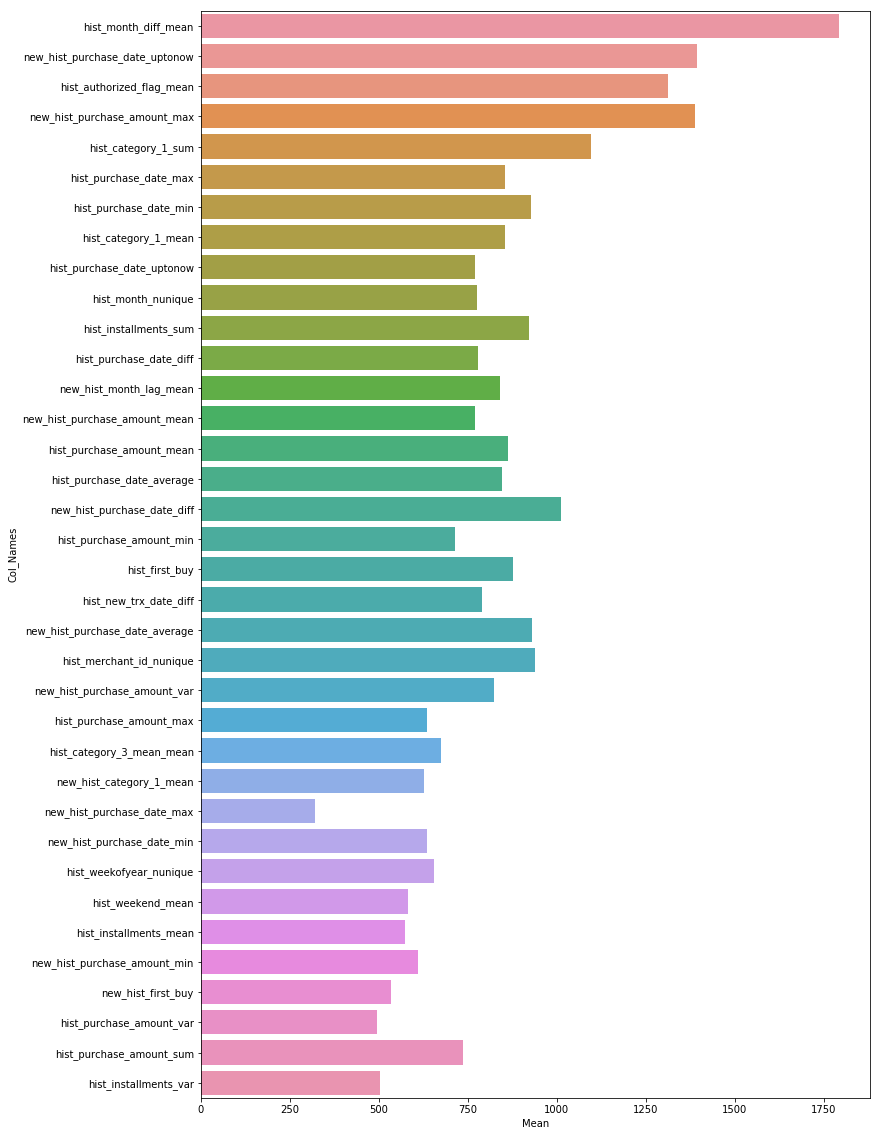

In [106]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,20))
sns.barplot(x="Mean", y="Col_Names", data = feature_imp1, orient='h',ax=ax)
plt.show()